In [1]:
import json
import joblib
import pickle
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
with open('dtypes_pre_process.pickle', 'rb') as fh:
    dtypes_pre = pickle.load(fh)
df_clean_path = '../capstone_train/df_clean.csv'
df_clean = pd.read_csv(df_clean_path, index_col=0).astype(dtypes_pre)

In [3]:
# Format station name
def beautify_station_name(station):
    station_spaced = station.replace('-',' ')
    capitalized_parts = station_spaced.split(" ")
    capitalized_parts[0] = capitalized_parts[0].capitalize()
    capitalized_parts[-1] = capitalized_parts[-1].capitalize()
    station_name_clean = " ".join(capitalized_parts)
    
    return station_name_clean

# SINGLE ( gender, ethnicity, age - Removal , Success)

In [4]:
# 0 = Gender Plot
# 1 = Ethnicity Plot
# 2 = Age Plot
plot_num = 0

# 0 - discrepancy in the Removal of more than just outer clothing
# 1- discrimination based on success percentage
objective_num = 0

top_stations_num = 10
top_up_or_down = False

In [5]:
# uniques
station_list = df_clean.station.unique()

gender_list = df_clean.Gender.unique()[:2]
ethnicity_list = df_clean['Officer-defined ethnicity'].unique()[[0,1,2,4]]
age_list = df_clean['Age range'].unique()[:-1]

sensitive_lists = [gender_list, ethnicity_list, age_list]
sensitive_list = sensitive_lists[plot_num]

sensitive_columns = ['Gender', 'Officer-defined ethnicity', 'Age range']
sensitive_column = sensitive_columns[plot_num]

sensitive_targets = ['Removal of more than just outer clothing', 'target']
sensitive_target = sensitive_targets[objective_num]

In [6]:
# Globally. to write on the Plot
data_globally = []
for g in sensitive_list:

    n_total = df_clean.loc[df_clean[sensitive_column] == g].shape[0]
    if n_total<30:
        continue

    if objective_num == 0:
        cond = df_clean['Removal of more than just outer clothing'] == True
    else:
        cond = df_clean['target'] == 1

    g_rem = df_clean.loc[(df_clean[sensitive_column] == g) & cond].shape[0]

    rem_g_percent = round(g_rem / n_total * 100, 2)

    data_globally.append([g, rem_g_percent, n_total])
    
df_globally = pd.DataFrame(data_globally, columns=[sensitive_column, 'percentage', 'total'])

In [7]:
# Each station. to Plot
data_station = []
for s in station_list:
    for g in sensitive_list:
        
        n_total = df_clean.loc[(df_clean.station == s) & (df_clean[sensitive_column] == g)].shape[0]
        if n_total<30:
            continue
            
        if objective_num == 0:
            cond = df_clean['Removal of more than just outer clothing'] == True
        else:
            cond = df_clean['target'] == 1
            
        g_rem = df_clean.loc[(df_clean.station == s) & (df_clean[sensitive_column] == g) & cond].shape[0]
        
        rem_g_percent = round(g_rem / n_total * 100, 2)
        
        data_station.append([s, g, rem_g_percent, n_total])
    
df_remove = pd.DataFrame(data_station, columns=['station', sensitive_column, 'percentage', 'total'])
df_remove.station = df_remove.station.apply(beautify_station_name)
df_remove

,station,Gender,percentage,total
0,Devon and Cornwall,Male,1.71,6391
1,Devon and Cornwall,Female,3.03,1157
2,Dyfed Powys,Male,7.80,3666
3,Dyfed Powys,Female,11.65,635
4,Derbyshire,Male,7.81,2572
...,...,...,...,...
77,Lancashire,Female,6.92,766
78,Greater Manchester,Male,2.24,4473
79,Greater Manchester,Female,3.55,366
80,Gwent,Male,0.00,710


In [8]:
# filter min and max percentage on each station in case of more than 2 uniques
df_new = pd.DataFrame(columns=['station', sensitive_column, 'percentage'])
for s in df_remove.station.unique():
    df_station = df_remove[df_remove.station == s]

    cond1 = df_station['percentage'] == df_station['percentage'].min()
    cond2 = df_station['percentage'] == df_station['percentage'].max()
    df_max_min = df_station[cond1|cond2]
    df_new = df_new.append(df_max_min)
    
df_new = df_new.groupby('station').filter(lambda x: x.shape[0]==2)
df_new = df_new.reset_index(drop=True)
df_new

,station,Gender,percentage,total
0,Devon and Cornwall,Male,1.71,6391.0
1,Devon and Cornwall,Female,3.03,1157.0
2,Dyfed Powys,Male,7.80,3666.0
3,Dyfed Powys,Female,11.65,635.0
4,Derbyshire,Male,7.81,2572.0
...,...,...,...,...
77,Lancashire,Female,6.92,766.0
78,Greater Manchester,Male,2.24,4473.0
79,Greater Manchester,Female,3.55,366.0
80,Gwent,Male,0.00,710.0


In [9]:
# Percentuage numbers
# from diff max and min on each station
# get top diff between extremes
top_diff_percent = df_new.reset_index(drop=True)
difff2 = abs(top_diff_percent['percentage'].diff())[1::2].sort_values(ascending=top_up_or_down)
dif_to_cal_avg = difff2
dif_to_percent_plot = difff2[:top_stations_num]

# Top station names
# get top diff station names from dif_to_percent_plot  index
top_diff_right_order = df_new.reindex(dif_to_percent_plot.index)
order_list = top_diff_right_order.station.values

# order bars by percentage in descending order
g = df_remove.groupby('station', group_keys=False)
df_remove = g.apply(lambda x: x.sort_values(by='percentage', ascending=False))

In [10]:
# the configuration assumes top 5
global_dist = 0.25
if plot_num==0:
    x_margin = 8 if objective_num == 0 else 25
    x_box = 1.5
    global_margin = 15 if objective_num == 0 else 42
    plot_colors = 'rainbow_r'
    name = 'Genders'
elif plot_num == 1:
    global_margin = 42
    x_margin = 25 if objective_num == 0 else 30
    x_box = 2 if objective_num == 0 else 2.2
    plot_colors = 'RdYlGn_r'
    name = 'Ethnicities'
else: 
    global_margin = 20 if objective_num == 0 else 40
    x_margin = 10 if objective_num == 0 else 25
    x_box = 1.5 if objective_num == 0 else 1.6
    plot_colors = 'rainbow_r'
    name = 'Age ranges'
    
if top_stations_num == 5:
    top_num_margin = 5.27
else:
    top_num_margin = 8
    x_box = 1.8
    global_dist = 0.35
    
if objective_num == 0:
    title_objective = "on asking for the removal of more than just outer clothing"
    axis_objective_label = 'cloth removal %'
else:
    title_objective = "on Search Success"
    axis_objective_label = 'search success %'
    
if top_up_or_down:
    top = 'smallest'
else:
    top = 'biggest'
    
print('plot_num', plot_num, 'objective_num', objective_num)

plot_num 0 objective_num 0


In [11]:
df_extreme_values = df_remove.sort_values(by=['percentage'], ascending=False)
df_range_values = df_new.sort_values(by=['percentage'], ascending=True)

# config plot bar values
plot_range_or_extremes = df_extreme_values
stack_or_individual_bars = True

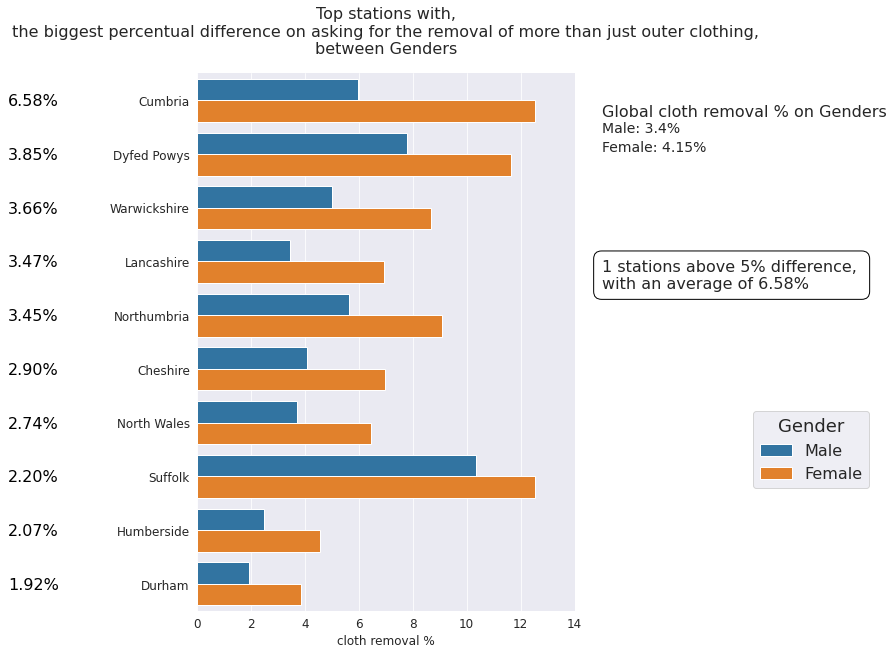

In [12]:
sns.set_style("darkgrid")

plot_colors = plot_colors
color = (sns.color_palette('tab10'))

g = sns.catplot(data=plot_range_or_extremes, kind="bar", x="percentage", y="station", palette=color,
                hue=sensitive_column, orient="h", height=top_num_margin, dodge=stack_or_individual_bars, 
                alpha=1, aspect=1/1.2, 
                order = order_list, sharex=True)

ax = g.facet_axis(0,0)

# Plot axis configurations
g.ax.set_title(f'Top stations with,\n the {top} percentual difference {title_objective}, \nbetween {name}',fontsize=16, pad=20)
g.ax.set_xlabel(xlabel=axis_objective_label, fontsize=12)
g.ax.set_ylabel(ylabel="", fontsize=16)
g.set_yticklabels(size = 12)
g.set_xticklabels(size = 12)

# Global average Data
g.ax.text(global_margin,0.3,f'Global {axis_objective_label} on {name}', fontsize=16) 
for i, global_ in df_globally.iterrows():
    ax.text(global_margin, 0.6+i*global_dist,f"{global_[sensitive_column]}: {round(global_.percentage,2)}%", fontsize=14)
    
# Stations average difference
diff_5 = dif_to_cal_avg[dif_to_cal_avg>5].shape[0]
diff_5_mean = round(dif_to_cal_avg[dif_to_cal_avg>5].mean(),2)
g.ax.text(global_margin, 3.5, f'{diff_5} stations above 5% difference, \nwith an average of {diff_5_mean}%', 
          fontsize=16, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5')) 

# Legend Plot
g._legend.remove()
ax.legend(title = sensitive_column,title_fontsize='18', prop=dict(size=16), loc="right", bbox_to_anchor = (x_box-0.0,0.3))

# Percentage stations
patch_h = []    
for i, p in enumerate(ax.patches):
    if i<top_stations_num:
        percent = round(dif_to_percent_plot.iloc[i],2)
        ax.text(p.get_x()-x_margin+1, p.get_y()+0.50, f"{percent:.2f}%",  color='black', rotation='horizontal', size=16)

# Tuple diff on each station

In [13]:
df_clean_path = '../capstone_train/df_discri.csv'
# load
df_clean_discri = pd.read_csv(df_clean_path, index_col=0)
df_clean_discri2 = df_clean_discri[df_clean_discri.total>30] 
df_clean_discri2

,station,Officer-defined ethnicity,Gender,Age range,percentage success,total
0,devon-and-cornwall,Asian,Male,18-24,21.88,32
5,devon-and-cornwall,White,Male,18-24,29.77,1733
6,devon-and-cornwall,White,Male,25-34,24.15,1474
7,devon-and-cornwall,White,Male,over 34,20.54,1704
8,devon-and-cornwall,White,Male,10-17,11.31,1123
...,...,...,...,...,...,...
987,greater-manchester,Other,Male,18-24,25.64,39
995,gwent,White,Male,18-24,0.00,226
996,gwent,White,Male,25-34,0.00,160
997,gwent,White,Male,over 34,0.00,118


In [14]:
df_clean_max_min = df_clean_discri2.copy()

df_clean_max_min['combined'] = "(" + df_clean_max_min['Officer-defined ethnicity'] + ", " + df_clean_max_min['Gender']  + ", " + df_clean_max_min['Age range'] + ")" 
df_clean_max_min = df_clean_max_min.drop(columns=['Officer-defined ethnicity', 'Gender', 'Age range'])

df_new = pd.DataFrame(columns=['station', 'percentage success', 'total', 'combined'])
for s in df_clean_max_min.station.unique():
    df_station = df_clean_max_min[df_clean_max_min.station == s]

    cond1 = df_station['percentage success'] == df_station['percentage success'].min()
    cond2 = df_station['percentage success'] == df_station['percentage success'].max()
    df_max_min = df_station[cond1|cond2]

    df_new = df_new.append(df_max_min)

df_new = df_new[~(df_new.station.isin(['gwent', 'humberside']))]

g = df_new.groupby('station', group_keys=False)
df_new = g.apply(lambda x: x.sort_values(by=['percentage success'],ascending=False))

In [15]:
df_clean_max_min.head()

,station,percentage success,total,combined
0,devon-and-cornwall,21.88,32,"(Asian, Male, 18-24)"
5,devon-and-cornwall,29.77,1733,"(White, Male, 18-24)"
6,devon-and-cornwall,24.15,1474,"(White, Male, 25-34)"
7,devon-and-cornwall,20.54,1704,"(White, Male, over 34)"
8,devon-and-cornwall,11.31,1123,"(White, Male, 10-17)"


In [16]:
top_n = 5

difff = abs(df_new['percentage success'].diff())
idexx = difff[1::2].sort_values(ascending=False).index[:top_n]
dif_to_plot = difff[1::2].sort_values(ascending=False)[:top_n]
order = df_new.loc[idexx]['station'].values
top_10_diff = df_new[df_new.station.isin(df_new.loc[idexx]['station'])]

g = top_10_diff.groupby('station', group_keys=False)
top_10_diff = g.apply(lambda x: x.sort_values(by=['percentage success'],ascending=False))

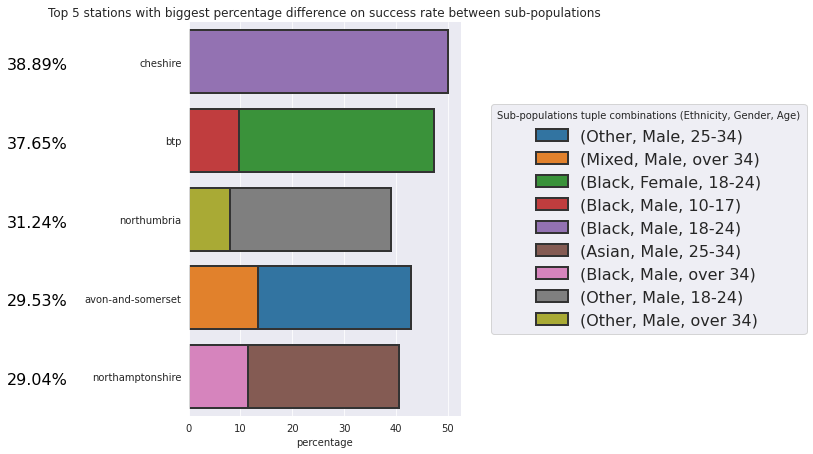

In [17]:
# Cheshire bar is ploting (Black, Male, 18-24), in front of (Black, Male, 10-17)
# because it is shorting by combined column for some reason instead of percentage
# see with top_10_diff.loc[top_10_diff.index == 144, 'combined'] = "(Black, Male,10-17)"

sns.set_style("darkgrid")
color = (sns.color_palette("tab10"))

g = sns.catplot(data=top_10_diff, x="percentage success", y="station",  kind="bar", palette=color, alpha=1, linewidth=2, errcolor=".2", edgecolor=".2",
                hue="combined", orient="h", height=6, order = order, sharey=False,dodge=False).set(title='Top 5 stations with biggest percentage difference on success rate between sub-populations')
g.set(xlabel="percentage", ylabel = "" )
g._legend.remove()
ax = g.facet_axis(0,0)
ax.legend(title = 'Sub-populations tuple combinations (Ethnicity, Gender, Age)', prop=dict(size=16), loc="right", bbox_to_anchor = (2.3,0.5))

for i ,p in enumerate(ax.patches):
    if i<top_n:
        percent = round(dif_to_plot.iloc[i], 2)
        ax.text(p.get_x() -35, p.get_y()+0.50, f"{percent:.2f}%",  color='black', rotation='horizontal', size=16)

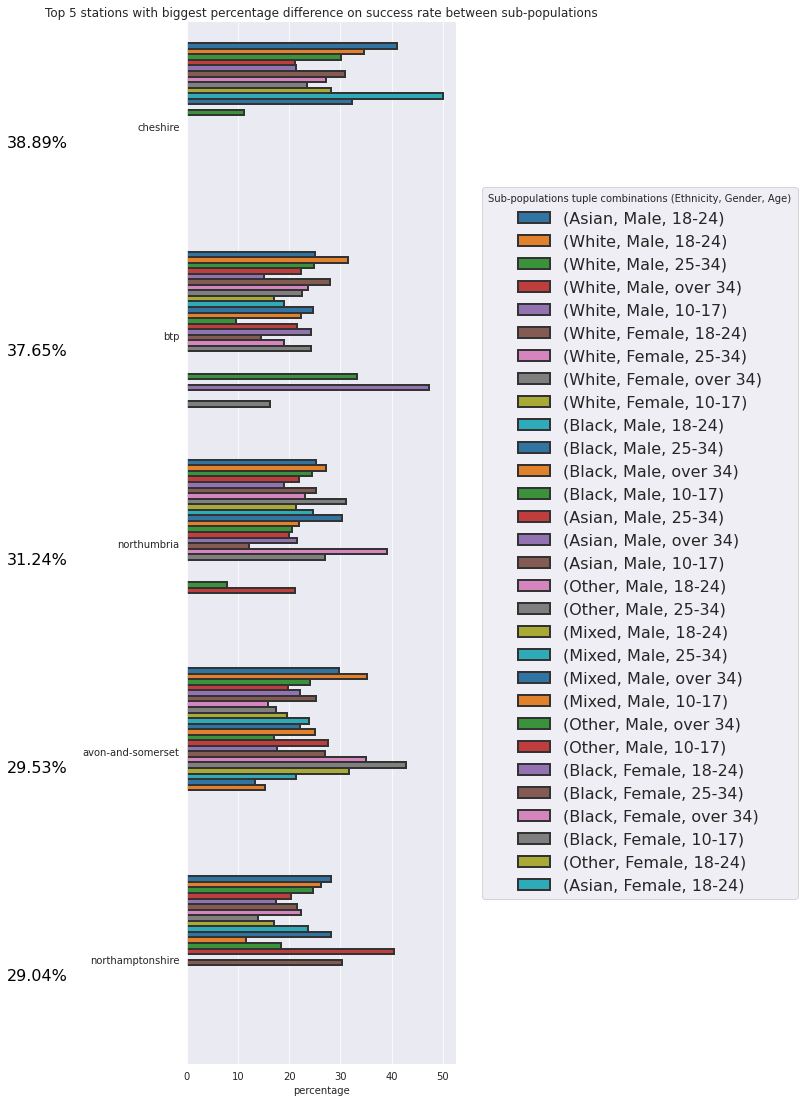

In [18]:
sns.set_style("darkgrid")
color = (sns.color_palette("tab10"))

g = sns.catplot(data=df_clean_max_min, x="percentage success", y="station",  kind="bar", palette=color, alpha=1, linewidth=2, errcolor=".2", edgecolor=".2",
                hue="combined", orient="h", height=15, aspect= 0.4,order = order, dodge=True).set(title='Top 5 stations with biggest percentage difference on success rate between sub-populations')
g.set(xlabel="percentage", ylabel = "" )
g._legend.remove()
ax = g.facet_axis(0,0)
ax.legend(title = 'Sub-populations tuple combinations (Ethnicity, Gender, Age)', prop=dict(size=16), loc="right", bbox_to_anchor = (2.3,0.5))

for i ,p in enumerate(ax.patches):
    if i<top_n:
        percent = round(dif_to_plot.iloc[i], 2)
        ax.text(p.get_x() -35, p.get_y()+0.50, f"{percent:.2f}%",  color='black', rotation='horizontal', size=16)